<a href="https://colab.research.google.com/github/Christophertdoc/convert-drone-detection-model/blob/main/drone_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.0 MB/s eta 0:00:00


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/1 /content/drive/MyDrive/Colab Notebooks/drone-detection/drone.jpg: 640x640 1 drone, 4172.4ms
Speed: 11.6ms preprocess, 4172.4ms inference, 34.5ms postprocess per image at shape (1, 3, 640, 640)


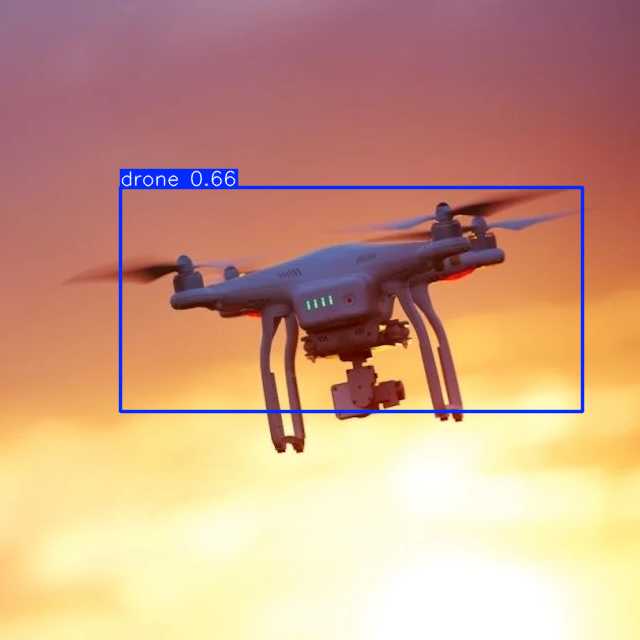


Annotated image saved to /content/drone_detection_yolo_predict.jpg


In [3]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow

# Load the YOLOv11 model
# Make sure the model path is correct. Based on your first cell, it might be at 'drone-detection/drone-detection-yolov11.pt'
model_path = '/content/drive/MyDrive/Colab Notebooks/drone-detection/drone-detection-yolov11.pt'
model = YOLO(model_path)
IMG_PATH = '/content/drive/MyDrive/Colab Notebooks/drone-detection/drone.jpg'

# Perform inference on the uploaded image
# Make sure IMG_PATH variable is set correctly from the previous steps
# conf stands for confidence threshold. It determines the minimum confidence score a detected object must have to be considered a valid detection. A higher conf value means you will only see detections that the model is more certain about. In your code, conf=0.3 means only detections with a confidence score of 0.3 or higher will be kept.
# iou threshold, the one with the lower confidence score is discarded. In your code, iou=0.5 means that if the overlap between two predicted boxes is 50% or more, and they are predicting the same class, the box with the lower confidence will be suppressed.
results = model.predict(source=IMG_PATH, conf=0.3, iou=0.5, show=False) # show=False to prevent immediate display

# The 'results' object contains the detections. We can access the annotated image.
# If results is a list (common for multiple images), take the first one.
annotated_image = results[0].plot() # .plot() returns the image with detections drawn on it

# Display the annotated image in Colab
cv2_imshow(annotated_image)

# Optionally save the annotated image
output_save_path = "/content/drone_detection_yolo_predict.jpg"
cv2.imwrite(output_save_path, annotated_image)
print(f"\nAnnotated image saved to {output_save_path}")

# Task
Export the YOLOv11 model to a mobile-optimized TFLite format, load the TFLite model, run inference on an image, and visualize the results.

## Export the model

### Subtask:
Export the YOLOv11 `.pt` model to a mobile-optimized TFLite format.


**Reasoning**:
Use the export method of the YOLO model to convert it to a mobile-optimized TFLite format as requested.



In [4]:
# Export the model to TFLite format with mobile optimization
tflite_model_path = 'drone-detection-yolov11_mobile.tflite'
model.export(format='tflite', optimize=True, name=tflite_model_path)

print(f"Model exported to {tflite_model_path}")

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/drive/MyDrive/Colab Notebooks/drone-detection/drone-detection-yolov11.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (109.1 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx>=1.12.0', 'onnx2tf>=1.26.3', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 10.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


TensorFlow SavedModel: starting export with tensorflow 2.19.0...

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.72...
ONNX: export success ✅ 33.7s, saved as '/content/drive/MyDrive/Colab Notebook

### Load the TFLite model

**Reasoning**:
Load the exported TFLite model using TensorFlow Lite Interpreter to prepare it for inference.

In [2]:
import tensorflow as tf

# Load the TFLite model
# Corrected path based on the file listing after export
tflite_model_path = '/content/drive/MyDrive/Colab Notebooks/drone-detection/drone-detection-yolov11_saved_model/drone-detection-yolov11_float32.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

print("TFLite model loaded successfully.")

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


TFLite model loaded successfully.


In [ ]:
import numpy as np

# Helper function to decode the raw YOLO output tensor
def decode_yolo_output(output_tensor, conf_thresh=0.25):
    """Decodes the raw output tensor from a YOLO TFLite model.

    Args:
        output_tensor: The raw output tensor from the TFLite interpreter.
                       Expected shape is typically (1, 5, N) or (1, N, 5)
                       where N is the number of anchor boxes and 5 represents
                       [x, y, w, h, confidence] or similar.

        conf_thresh: Confidence threshold for filtering detections.

    Returns:
        A list of dictionaries, where each dictionary represents a detection
        and contains 'box' (xyxy format) and 'score'.
    """
    # Adjust shape if needed (transpose if output is (1, 5, N))
    if output_tensor.shape[1] == 5 and output_tensor.shape[2] > 5:
         output_tensor = np.transpose(output_tensor, (0, 2, 1))
    # Ensure the shape is (1, N, 5) for processing
    elif output_tensor.shape[2] != 5:
         print(f"Warning: Unexpected output tensor shape: {output_tensor.shape}. Assuming format is [x, y, w, h, confidence] along the last dimension.")
         # Attempt to reshape if possible, otherwise raise an error
         try:
             output_tensor = output_tensor.reshape(output_tensor.shape[0], -1, 5)
         except ValueError:
             raise ValueError(f"Could not reshape output tensor of shape {output_tensor.shape} to (batch_size, N, 5).")


    detections = []
    for detection in output_tensor[0]:
        # The assumed output format is [x, y, w, h, confidence]
        # Adjust indices if your model's output format is different
        center_x, center_y, width, height, confidence = detection[:5]

        if confidence > conf_thresh:
            # Convert box from [x, y, w, h] to [x1, y1, x2, y2] (xyxy)
            # The coordinates are relative to the input image size (640x640)
            x1 = center_x - width / 2
            y1 = center_y - height / 2
            x2 = center_x + width / 2
            y2 = center_y + height / 2

            detections.append({
                "box": [x1, y1, x2, y2],
                "score": float(confidence)
            })
    return detections

# Helper function for Non-Maximum Suppression (NMS)
def nms(detections, iou_thr=0.45):
    """Adds Non-Maximum Suppression to a list of detections.

    Args:
        detections: A list of dictionaries, where each dictionary represents a detection
                    and contains 'box' (xyxy format) and 'score'.
        iou_thr: IoU threshold for NMS.

    Returns:
        A list of dictionaries representing the filtered detections after NMS.
    """
    if not detections:
        return []

    # Convert detections to numpy arrays for efficient processing
    boxes = np.array([d["box"] for d in detections])
    scores = np.array([d["score"] for d in detections])

    # Calculate areas of bounding boxes
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    # Sort detections by confidence score in descending order
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(detections[i]) # Append the original detection dictionary

        # Calculate IoU of the current detection with the rest
        xx1 = np.maximum(boxes[i, 0], boxes[order[1:], 0])
        yy1 = np.maximum(boxes[i, 1], boxes[order[1:], 1])
        xx2 = np.minimum(boxes[i, 2], boxes[order[1:], 2])
        yy2 = np.minimum(boxes[i, 3], boxes[order[1:], 3])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h

        iou = inter / (areas[i] + areas[order[1:]] - inter)

        # Keep detections with IoU less than the threshold
        inds = np.where(iou <= iou_thr)[0]
        order = order[inds + 1] # +1 because inds are relative to order[1:]

    return keep

# Helper function to map detection boxes from model input coordinates to original image coordinates
def model_to_orig(box, scale_x, scale_y):
    """Maps a bounding box from model input coordinates back to original image coordinates.

    Args:
        box: Bounding box in xyxy format relative to the model input size (640x640).
        scale_x: The scaling factor for the x-coordinates (original_width / model_width).
        scale_y: The scaling factor for the y-coordinates (original_height / model_height).


    Returns:
        Bounding box in xyxy format relative to the original image size.
    """
    x1, y1, x2, y2 = box

    # Scale back to original image size
    x1 *= scale_x
    y1 *= scale_y
    x2 *= scale_x
    y2 *= scale_y

    return [x1, y1, x2, y2]

In [1]:
# Process the raw output tensor
# Reuse the decode_yolo_output and nms functions defined earlier

# Print the shape of the output tensor
print(f"Raw output tensor shape: {output_tensor.shape}")

raw_dets = decode_yolo_output(output_tensor, conf_thresh=0.01) # Lower conf_thresh to see more potential detections
print(f"Number of raw detections before NMS: {len(raw_dets)}")

# Sort raw detections by score in descending order and print top few scores and boxes
raw_dets_sorted = sorted(raw_dets, key=lambda d: d["score"], reverse=True)
print("Top 10 raw detections (score, box):")
for det in raw_dets_sorted[:10]:
    print(f"  Score: {det['score']:.4f}, Box: [{det['box'][0]:.2f}, {det['box'][1]:.2f}, {det['box'][2]:.2f}, {det['box'][3]:.2f}]")


dets = nms(raw_dets, iou_thr=0.45) # Adjust iou_thr as needed
print(f"Number of detections after NMS: {len(dets)}")

# Get original image shape and model input shape
original_height, original_width = orig_bgr.shape[:2]
model_input_height, model_input_width = IMG_SIZE, IMG_SIZE # Assuming model input is 640x640

# Calculate scaling factors
scale_x = original_width / model_input_width
scale_y = original_height / model_input_height


# Map boxes back to original image coordinates and visualize
# Reuse the model_to_orig function defined earlier
vis = orig_bgr.copy() # Use the original image loaded earlier
for d in dets:
    # Use the calculated scaling factors
    x1_rel, y1_rel, x2_rel, y2_rel = model_to_orig(d["box"], scale_x, scale_y)

    # Convert relative coordinates to absolute pixel coordinates
    x1 = x1_rel * original_width
    y1 = y1_rel * original_height
    x2 = x2_rel * original_width
    y2 = y2_rel * original_height

    # Print the mapped coordinates before casting to int
    print(f"Mapped box coordinates (pixel): [{x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f}]")

    p1, p2 = (int(x1), int(y1)), (int(x2), int(y2))
    cv2.rectangle(vis, p1, p2, (0,255,0), 2)
    label = f"{d['score']:.2f}"
    cv2.putText(vis, label, (p1[0], max(0,p1[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

out_path = "/content/drone_detection_tflite_result.jpg"
cv2.imwrite(out_path, vis[:, :, ::-1]) # ensure BGR write
print("Saved:", out_path)

# Show inline
from IPython.display import display
from PIL import Image
display(Image.fromarray(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)))

NameError: name 'output_tensor' is not defined